# Map generation

In [154]:
# Function to read a file, reverse its content, and write to a new file
def reverse_and_save_file(input_file_path, output_file_path):
    with open(input_file_path, 'r') as file:
        lines = file.readlines()
        # Reverse the order of lines
        lines_reversed = lines[::-1]

    with open(output_file_path, 'w') as file:
        for line in lines_reversed:
            # Write each reversed line back to the new file
            file.write(line)

# File paths for path2 and path3
path2_file_path = '/Users/apple/Desktop/robotic_project/sGOOter_project/controllers/gps/path2.txt'
path3_file_path = '/Users/apple/Desktop/robotic_project/sGOOter_project/controllers/gps/path3.txt'

# Output file paths for reversed paths
path2_output_file_path = '/Users/apple/Desktop/robotic_project/sGOOter_project/controllers/gps/path2_reversed.txt'
path3_output_file_path = '/Users/apple/Desktop/robotic_project/sGOOter_project/controllers/gps/path3_reversed.txt'

# Reverse the files and save to new locations
reverse_and_save_file(path2_file_path, path2_output_file_path)
reverse_and_save_file(path3_file_path, path3_output_file_path)

def parse_coordinates(file_paths):
    paths = []
    for file_path in file_paths:
        coordinates = []
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.strip().split(',')
                if len(parts) >= 3:
                    x = float(parts[1].strip())  # Assuming the second element is x
                    y = float(parts[2].strip())  # Assuming the third element is y
                    coordinates.append((x, y))
        paths.append(coordinates)
    return paths
other_paths = parse_coordinates([path2_output_file_path, path3_output_file_path])


In [155]:
import os

def parse_and_save_coordinates(file_paths, output_file):
    all_paths = []
    for file_path in file_paths:
        coordinates = []
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.strip().split(',')
                if len(parts) >= 3:
                    x = float(parts[1].strip())  # Assuming the second element is x
                    y = float(parts[2].strip())  # Assuming the third element is y
                    coordinates.append((x, y))
        all_paths.append(coordinates)
    
    # Now write all paths to a single file
    with open(output_file, 'w') as out_file:
        for path in all_paths:
            for coord in path:
                out_file.write(f"{coord[0]}, {coord[1]}\n")
            out_file.write("# New Path\n")  # Delimiter for new paths

# List of file paths
file_paths = [
    
    '/Users/apple/Desktop/robotic_project/sGOOter_project/controllers/gps/path1.txt',
    '/Users/apple/Desktop/robotic_project/sGOOter_project/controllers/gps/path4.txt',
    '/Users/apple/Desktop/robotic_project/sGOOter_project/controllers/gps/start.txt',
    '/Users/apple/Desktop/robotic_project/sGOOter_project/controllers/gps/park.txt'
]

# Output file path
output_file = '/Users/apple/Desktop/robotic_project/sGOOter_project/controllers/gps/map_routes.txt'

# Parse the coordinates from all files and save to one file
parse_and_save_coordinates(file_paths, output_file)

# Load map

In [156]:
def load_paths_from_file(input_file):
    all_paths = []
    current_path = []
    with open(input_file, 'r') as file:
        for line in file:
            if line.strip() == "# New Path":
                if current_path:
                    all_paths.append(current_path)
                    current_path = []
            else:
                parts = line.strip().split(',')
                if len(parts) == 2:
                    x, y = float(parts[0].strip()), float(parts[1].strip())
                    current_path.append((x, y))
        if current_path:  # Add the last path if file does not end with delimiter
            all_paths.append(current_path)
    return all_paths

# Now you can load all paths with a single call
all_paths = load_paths_from_file(output_file)


path planning

In [157]:
import math
from heapq import heappop, heappush

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.neighbors = []
        self.cost = float('inf')
        self.estimate = float('inf')
        self.parent = None

    def add_neighbor(self, neighbor):
        self.neighbors.append(neighbor)
    
    def __lt__(self, other):
        return self.estimate < other.estimate

def euclidean_distance(node1, node2):
    return math.sqrt((node1.x - node2.x) ** 2 + (node1.y - node2.y) ** 2)

def find_closest_node(nodes, x, y):
    min_distance = float('inf')
    closest_node = None
    for node in nodes:
        distance = euclidean_distance(node, Node(x, y))
        if distance < min_distance:
            min_distance = distance
            closest_node = node
    return closest_node

def connect_nodes(nodes, connection_range):
    for node in nodes:
        for other in nodes:
            if node != other and euclidean_distance(node, other) <= connection_range:
                node.add_neighbor(other)

def a_star(start, goal, y_constraint_length=20):
    open_set = []
    heappush(open_set, (start.estimate, start))
    start.cost = 0
    start.estimate = euclidean_distance(start, goal)

    while open_set:
        current = heappop(open_set)[1]

        if current == goal:
            potential_path = reconstruct_path(goal)
            if is_path_valid(potential_path, y_constraint_length):
                return potential_path
            else:
                continue  # Skip this path as it doesn't meet the y-value constraint

        for neighbor in current.neighbors:
            # Ensure the path remains valid with the y-direction constraint
            if len(reconstruct_path(current)) < y_constraint_length and neighbor.y < current.y:
                continue  # Skip adding this neighbor if it violates the increasing y constraint

            tentative_cost = current.cost + euclidean_distance(current, neighbor)
            if tentative_cost < neighbor.cost:
                neighbor.cost = tentative_cost
                neighbor.estimate = tentative_cost + euclidean_distance(neighbor, goal)
                neighbor.parent = current
                heappush(open_set, (neighbor.estimate, neighbor))

    return None  # Return None if no valid path is found


def reconstruct_path(goal):
    path = []
    current = goal
    while current:
        path.append((current.x, current.y))
        current = current.parent
    path.reverse()
    return path

def is_path_valid(path, y_constraint_length):
    # Check if the first 30 nodes (or the whole path if shorter) have increasing y values
    if len(path) >= y_constraint_length:
        constrained_part = path[:y_constraint_length]
    else:
        constrained_part = path

    return all(constrained_part[i][1] < constrained_part[i + 1][1] for i in range(len(constrained_part) - 1))



# Create all nodes for each path
all_nodes = [Node(coord[0], coord[1]) for path in all_paths for coord in path]

# Connect nodes within a specified connection range
connection_range = 5  # Set the connection range within which nodes can interconnect
connect_nodes(all_nodes, connection_range)

# Input start and goal coordinates
# start_x, start_y = map(float, input("Enter start coordinates (x, y): ").split(','))
# goal_x, goal_y = map(float, input("Enter goal coordinates (x, y): ").split(','))

# Find the closest nodes to the given coordinates
start_node = find_closest_node(all_nodes, 50.05, -106.24)
goal_node = find_closest_node(all_nodes, -39.51, -87.47)

# Execute A* algorithm
path = a_star(start_node, goal_node)

# Output the path
if path:
    for step in path:
        print(step)
else:
    print("No path found from start to goal.")



(50.05, -106.24)
(49.71, -102.3)
(49.73, -98.35)
(49.4, -94.39)
(49.22, -90.44)
(49.26, -86.49)
(49.51, -82.55)
(49.37, -78.58)
(49.5, -74.62)
(49.97, -70.71)
(50.46, -66.77)
(50.39, -62.8)
(50.37, -58.85)
(50.59, -54.92)
(50.5, -50.95)
(50.44, -46.99)
(50.47, -43.04)
(50.42, -39.09)
(50.31, -34.77)
(50.32, -30.82)
(50.33, -26.85)
(50.33, -22.88)
(50.34, -18.93)
(50.36, -14.98)
(50.37, -11.01)
(50.38, -7.05)
(50.38, -3.1)
(50.33, 0.86)
(50.17, 4.82)
(49.75, 8.76)
(49.11, 12.65)
(48.22, 16.51)
(46.9, 20.26)
(45.37, 23.9)
(43.56, 27.41)
(41.36, 30.71)
(38.93, 33.84)
(36.23, 36.72)
(33.3, 39.38)
(30.13, 41.77)
(26.77, 43.86)
(23.25, 45.66)
(19.58, 47.14)
(15.77, 48.26)
(11.91, 49.09)
(7.99, 49.64)
(4.04, 49.93)
(0.07, 50.12)
(-3.87, 50.23)
(-7.83, 50.28)
(-11.8, 50.32)
(-15.76, 50.34)
(-19.7, 50.35)
(-23.67, 50.35)
(-27.64, 50.35)
(-31.59, 50.4)
(-35.54, 50.36)
(-39.51, 50.34)
(-43.47, 50.34)
(-47.42, 50.34)
(-51.38, 50.36)
(-55.35, 50.37)
(-59.31, 50.36)
(-63.25, 50.25)
(-67.21, 49.96)
(

#50.05, -106.24 start
#-39.51, -87.47 end 

#-108.79, 13.44 start
#50.35, -32.94

# Visualization

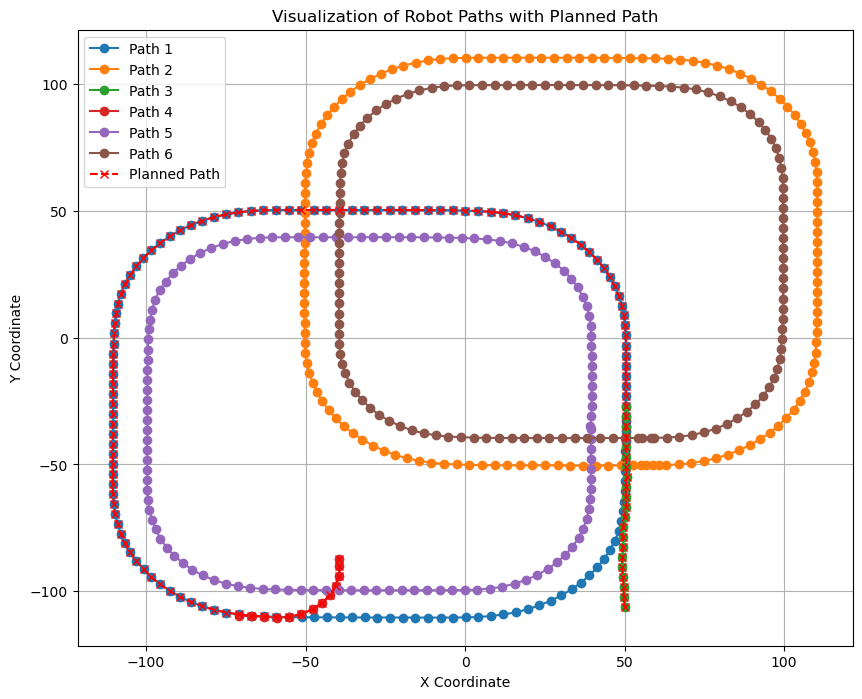

In [158]:
import matplotlib.pyplot as plt

def plot_paths_and_planned(paths, planned_path):
    plt.figure(figsize=(10, 8))
    # Plot all the original paths
    for index, coordinates in enumerate(paths):
        x_vals, y_vals = zip(*coordinates)  # Unpack the list of tuples into two lists
        plt.plot(x_vals, y_vals, marker='o', linestyle='-', label=f'Path {index + 1}')
    
    # Plot the planned path
    if planned_path:
        x_planned, y_planned = zip(*planned_path)  # Unpack the list of tuples into two lists
        plt.plot(x_planned, y_planned, marker='x', linestyle='--', color='r', label='Planned Path')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Visualization of Robot Paths with Planned Path')
    plt.legend()
    plt.grid(True)
    plt.show()
# Assuming 'path' is the result from your A* algorithm
all_paths1 = all_paths + other_paths
plot_paths_and_planned(all_paths1, path)
